In [242]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.decomposition import PCA
import graphviz
from sklearn.preprocessing import StandardScaler
import local_helpers as lh
import pingouin as pg
import pydotplus
import math

# Prepare Dataset

Import the preprocessed data set, which was preprocessed in the `data_preparation.ipynb` notebook

In [105]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv',
                        dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string',
                               'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')

df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,date_time
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 00:00:00
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,2015-01-01 00:00:00
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,2015-01-01 01:00:00
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427,2015-01-01 01:00:00


## Prepare Data set
### Calculate Demand per Hour

First of all, it is necessary to transform the data set such that we obtain a time series with hourly frequency providing the demand for bike rentals. We define demand as the number of bike rentals that started in a given hour. 

In [106]:
df_demand = df_boston.resample(rule='H', on='start_time').size().reset_index(name='demand')
df_demand.columns = ['date_time', 'demand']
df_demand.head()


,date_time,demand
0,2015-01-01 00:00:00,4
1,2015-01-01 01:00:00,3
2,2015-01-01 02:00:00,1
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,1


### Include Weather Data
Next, the weather data is included into the dataset. For this we just need to merge the two datasets, as both are already in hourly frequency. 

In [107]:
df_weather = pd.read_csv('./data/weather_hourly_boston.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_demand = df_demand.merge(df_weather, how='left', on='date_time')

df_hourly_demand = df_demand.copy()
df_demand.head()

,date_time,demand,max_temp,min_temp,precip
0,2015-01-01 00:00:00,4,NaN,NaN,NaN
1,2015-01-01 01:00:00,3,NaN,NaN,NaN
2,2015-01-01 02:00:00,1,NaN,NaN,NaN
3,2015-01-01 03:00:00,0,NaN,NaN,NaN
4,2015-01-01 04:00:00,1,NaN,NaN,NaN


# Feature Engineering

## Previous demand as input

As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

* 2 hour: The asssumption is that the demand should not change dramatically between three hours.
* 24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.
* Average demand of the past week at the same day time: This feature is the average of all 7 demand observations of the past week at same time of the day. 

In [108]:
df_demand['demand_h-2'] = df_demand.demand.shift(periods=2)
df_demand['demand_h-24'] = df_demand.demand.shift(periods=24)

df_demand['demand_tmp_h-48'] = df_demand.demand.shift(periods=48)
df_demand['demand_tmp_h-72'] = df_demand.demand.shift(periods=72)
df_demand['demand_tmp_h-96'] = df_demand.demand.shift(periods=96)
df_demand['demand_tmp_h-120'] = df_demand.demand.shift(periods=120)
df_demand['demand_tmp_h-144'] = df_demand.demand.shift(periods=144)
df_demand['demand_tmp_h-168'] = df_demand.demand.shift(periods=144)

df_demand['demand_average_w-1'] = df_demand[
    ['demand_h-24', 'demand_tmp_h-48', 'demand_tmp_h-72', 'demand_tmp_h-96', 'demand_tmp_h-120', 'demand_tmp_h-144',
     'demand_tmp_h-168']].mean(axis=1)
df_demand = df_demand.drop(
    ['demand_tmp_h-48', 'demand_tmp_h-72', 'demand_tmp_h-96', 'demand_tmp_h-120', 'demand_tmp_h-144',
     'demand_tmp_h-168'], axis=1)
df_demand.tail()

,date_time,demand,max_temp,min_temp,precip,demand_h-2,demand_h-24,demand_average_w-1
9226,2015-12-31 19:00:00,26,7.2,7.2,0.0,42.0,7.0,27.285714
9227,2015-12-31 20:00:00,10,7.2,7.2,0.0,27.0,4.0,34.000000
9228,2015-12-31 21:00:00,17,6.1,6.1,0.0,26.0,1.0,34.857143
9229,2015-12-31 22:00:00,18,5.6,5.6,0.0,10.0,2.0,31.857143
9230,2015-12-31 23:00:00,13,5.6,5.6,0.0,17.0,2.0,30.285714


## Weather features
In the descriptive analysis, precisley the time demand pattern analysis, we have found out that the temperature and demand curve follow similar directions. Therefore we construct features based on the temperature to enable models to capture this relationship.

### Average temperature

The average temperature feature is a simple feature which is calculated by taking the mean of minimum and maximum temperature of an hour

In [109]:
df_demand['avg_temp'] = (df_demand.min_temp + df_demand.max_temp) / 2
df_demand.head()

,date_time,demand,max_temp,min_temp,precip,demand_h-2,demand_h-24,demand_average_w-1,avg_temp
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,3.0,NaN,NaN,NaN
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN


### Temperature change within hour
This feature is calculated by subtracting the minimum temperature from the maximum temperature. It describes the change of temperature in a given hour.

In [110]:
df_demand['temp_change'] = df_demand.max_temp - df_demand.min_temp

### Precipitation
We haven proven in `time_demand_patterns.ipynb` that precipitation has a significant impact on demand change. Hence we construct a feature that describes whether it has rained in the last two hours.

In [111]:
df_demand['precip_h-1'] = df_demand.precip.shift(periods=1)
df_demand['precip_h-2'] = df_demand.precip.shift(periods=2)

df_demand['precip_l2h'] = df_demand[['precip', 'precip_h-1', 'precip_h-2']].sum(axis=1)
df_demand = df_demand.drop(['precip_h-1', 'precip_h-2'], axis=1)


## Time features
In the following we construct features that are based on the timestamp. In our descriptive analysis we have seen that demand varies significantly over the season & time of the day

### Hour Feature
The descriptive analysis has shown that the hour of the day servers as a good predictor for the demand. As we will use algorithms such as KNN, which heavily rely on distances, we need to transform the hour feature in order retain the cyclical behaviour of an hour clock. We do this by splitting the hour feature into two parts: A sinus transformation and consinus transformation. This feature will only be used by KNN.

In [112]:
# Extract date and time features
df_demand['hour'] = df_demand['date_time'].dt.strftime('%Y-%m-%d %X').apply(lambda x: int(x.split()[1].split(':')[0]))
df_demand['sin_hour'] = np.sin(2 * np.pi * df_demand.hour / 24)
df_demand['cos_hour'] = np.cos(2 * np.pi * df_demand.hour / 24)
df_demand.drop(['hour'], axis=1)

,date_time,demand,max_temp,min_temp,precip,demand_h-2,demand_h-24,demand_average_w-1,avg_temp,temp_change,precip_l2h,sin_hour,cos_hour
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,1.000000
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.258819,0.965926
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,0.0,0.500000,0.866025
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.0,0.707107,0.707107
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9226,2015-12-31 19:00:00,26,7.2,7.2,0.0,42.0,7.0,27.285714,7.2,0.0,0.0,-0.965926,0.258819
9227,2015-12-31 20:00:00,10,7.2,7.2,0.0,27.0,4.0,34.000000,7.2,0.0,0.0,-0.866025,0.500000
9228,2015-12-31 21:00:00,17,6.1,6.1,0.0,26.0,1.0,34.857143,6.1,0.0,0.0,-0.707107,0.707107
9229,2015-12-31 22:00:00,18,5.6,5.6,0.0,10.0,2.0,31.857143,5.6,0.0,0.0,-0.500000,0.866025


### Season 
The time demand pattern analysis has also shown that demand changes depending on the season, especially in summer months demand is high while demand is low during winter. Hence we construct a feature for each season.

In [113]:
def determine_season(row):
    if datetime(2015, 12, 22) <= row.date_time or row.date_time < datetime(2015, 3, 20):
        return 'winter'
    elif datetime(2015, 3, 20) <= row.date_time < datetime(2015, 6, 21):
        return 'spring'
    elif datetime(2015, 6, 21) <= row.date_time < datetime(2015, 9, 23):
        return 'summer'
    else:
        return 'autumn'


df_demand['season'] = df_demand.apply((lambda x: determine_season(x)), axis=1)
df_demand = pd.get_dummies(df_demand, columns=['season'])
df_demand.head()

,date_time,demand,max_temp,min_temp,precip,demand_h-2,demand_h-24,demand_average_w-1,avg_temp,temp_change,precip_l2h,hour,sin_hour,cos_hour,season_autumn,season_spring,season_summer,season_winter
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.000000,1.000000,0,0,0,1
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.258819,0.965926,0,0,0,1
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,0.0,2,0.500000,0.866025,0,0,0,1
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.0,3,0.707107,0.707107,0,0,0,1
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4,0.866025,0.500000,0,0,0,1


### Weekend feature
In the descriptive analysis we have seen that on saturday and sunday the demand particularly low, hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [114]:
df_demand['weekend'] = df_demand.apply((lambda x: 0 if x.date_time.weekday() < 5 else 1), axis=1)

#### Daytime features
Further the descriptive analysis has shown that the daytime, i.e. if it is night, morning, afternoon or evening, plays an important role for the demand. Hence, we engineer four features that respectively indicate if a rides takes place during
* Morning: 6am - 12pm
* Afternoon: 12pm - 6pm
* Evening: 6pm - 11pm
* Night: 12am - 6am

In [115]:
df_demand['daytime'] = df_demand["date_time"].apply(lambda x: lh.get_pnt_day_with_pnt_week(x))
df_demand = pd.get_dummies(df_demand, columns=['daytime'])

### Event Features
Events such as public holidays or going into low season mode by closing down stations might influence the demand. In order to capture these patterns we introduce two variables
#### Public Holiday Feature
There were several public holidays in Boston:
* New Year's Day: Friday, January 1
* Martin Luther King Jr. Day: Monday, January 19
* Presidents' Day: Monday, February 16
* Patriots' Day: Monday, April 20
* Memorial Day: Monday, May 25
* Independence Day: Saturday, July 4
* Labor Day: Monday, September 7
* Columbus Day: Monday, October 12
* Veterans Day: Wednesday, November 11
* Thanksgiving Day: Thursday, November 26
* Christmas Day: Friday, December 25

These events might have influenced the demand

In [116]:
holiday_dates = [datetime(2015, 1, 1), datetime(2015, 1, 19), datetime(2015, 2, 16), datetime(2015, 4, 20),
                 datetime(2015, 5, 25), datetime(2015, 7, 4), datetime(2015, 9, 7), datetime(2015, 10, 12),
                 datetime(2015, 11, 11), datetime(2015, 11, 26), datetime(2015, 12, 25)]

df_demand['public_holiday'] = df_demand.apply((lambda x: 1 if x.date_time in holiday_dates else 0), axis=1)

#### Low & High Season Feature
Between Nov 25 and April 17 Hubway is not operating all stations, hence we have seen a significant drop in rides in our descriptive analysis during these months. We there introduce a feature which indicates whether the current timestamp is in low or high season.

![caption](data/low_season_times.png)

In [117]:
df_demand['low_season'] = df_demand.apply(
    (lambda x: 1 if x.date_time > datetime(2015, 11, 25) or x.date_time < datetime(2015, 4, 17) else 0), axis=1)

## Analyze correlation between features

We have different measurement scales:

Ordinal(natural order, but no quantifiable difference between values or binary):
- precip
- season_x
- daytime_x
- public_holiday
Metric(equidistant scale):
- demand
- avg_temp
- temp_change

We do 2 different analysis:
- Metric <-> Metric (Pearson)
- Ordinal <-> Metric, Ordinal <-> Ordinal (Spearman)

<AxesSubplot:>

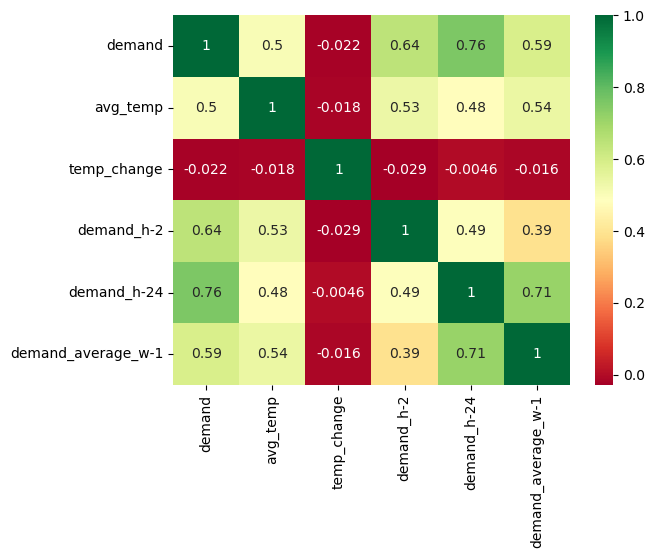

In [118]:
ordinal = df_demand[
    ["precip", "season_autumn", "season_spring", "season_summer", "season_winter", "daytime_morning_week",
     "daytime_afternoon_week", "daytime_evening_week", "daytime_night_week", "daytime_morning_weekend",
     "daytime_afternoon_weekend", "daytime_evening_weekend", "daytime_night_weekend", "public_holiday", "precip_l2h",
     "low_season", "hour", "weekend"]]
metric = df_demand[["demand", "avg_temp", "temp_change", "demand_h-2", "demand_h-24", "demand_average_w-1"]]

sns.heatmap(metric.corr(method="pearson"), annot=True, cmap="RdYlGn")

<AxesSubplot:>

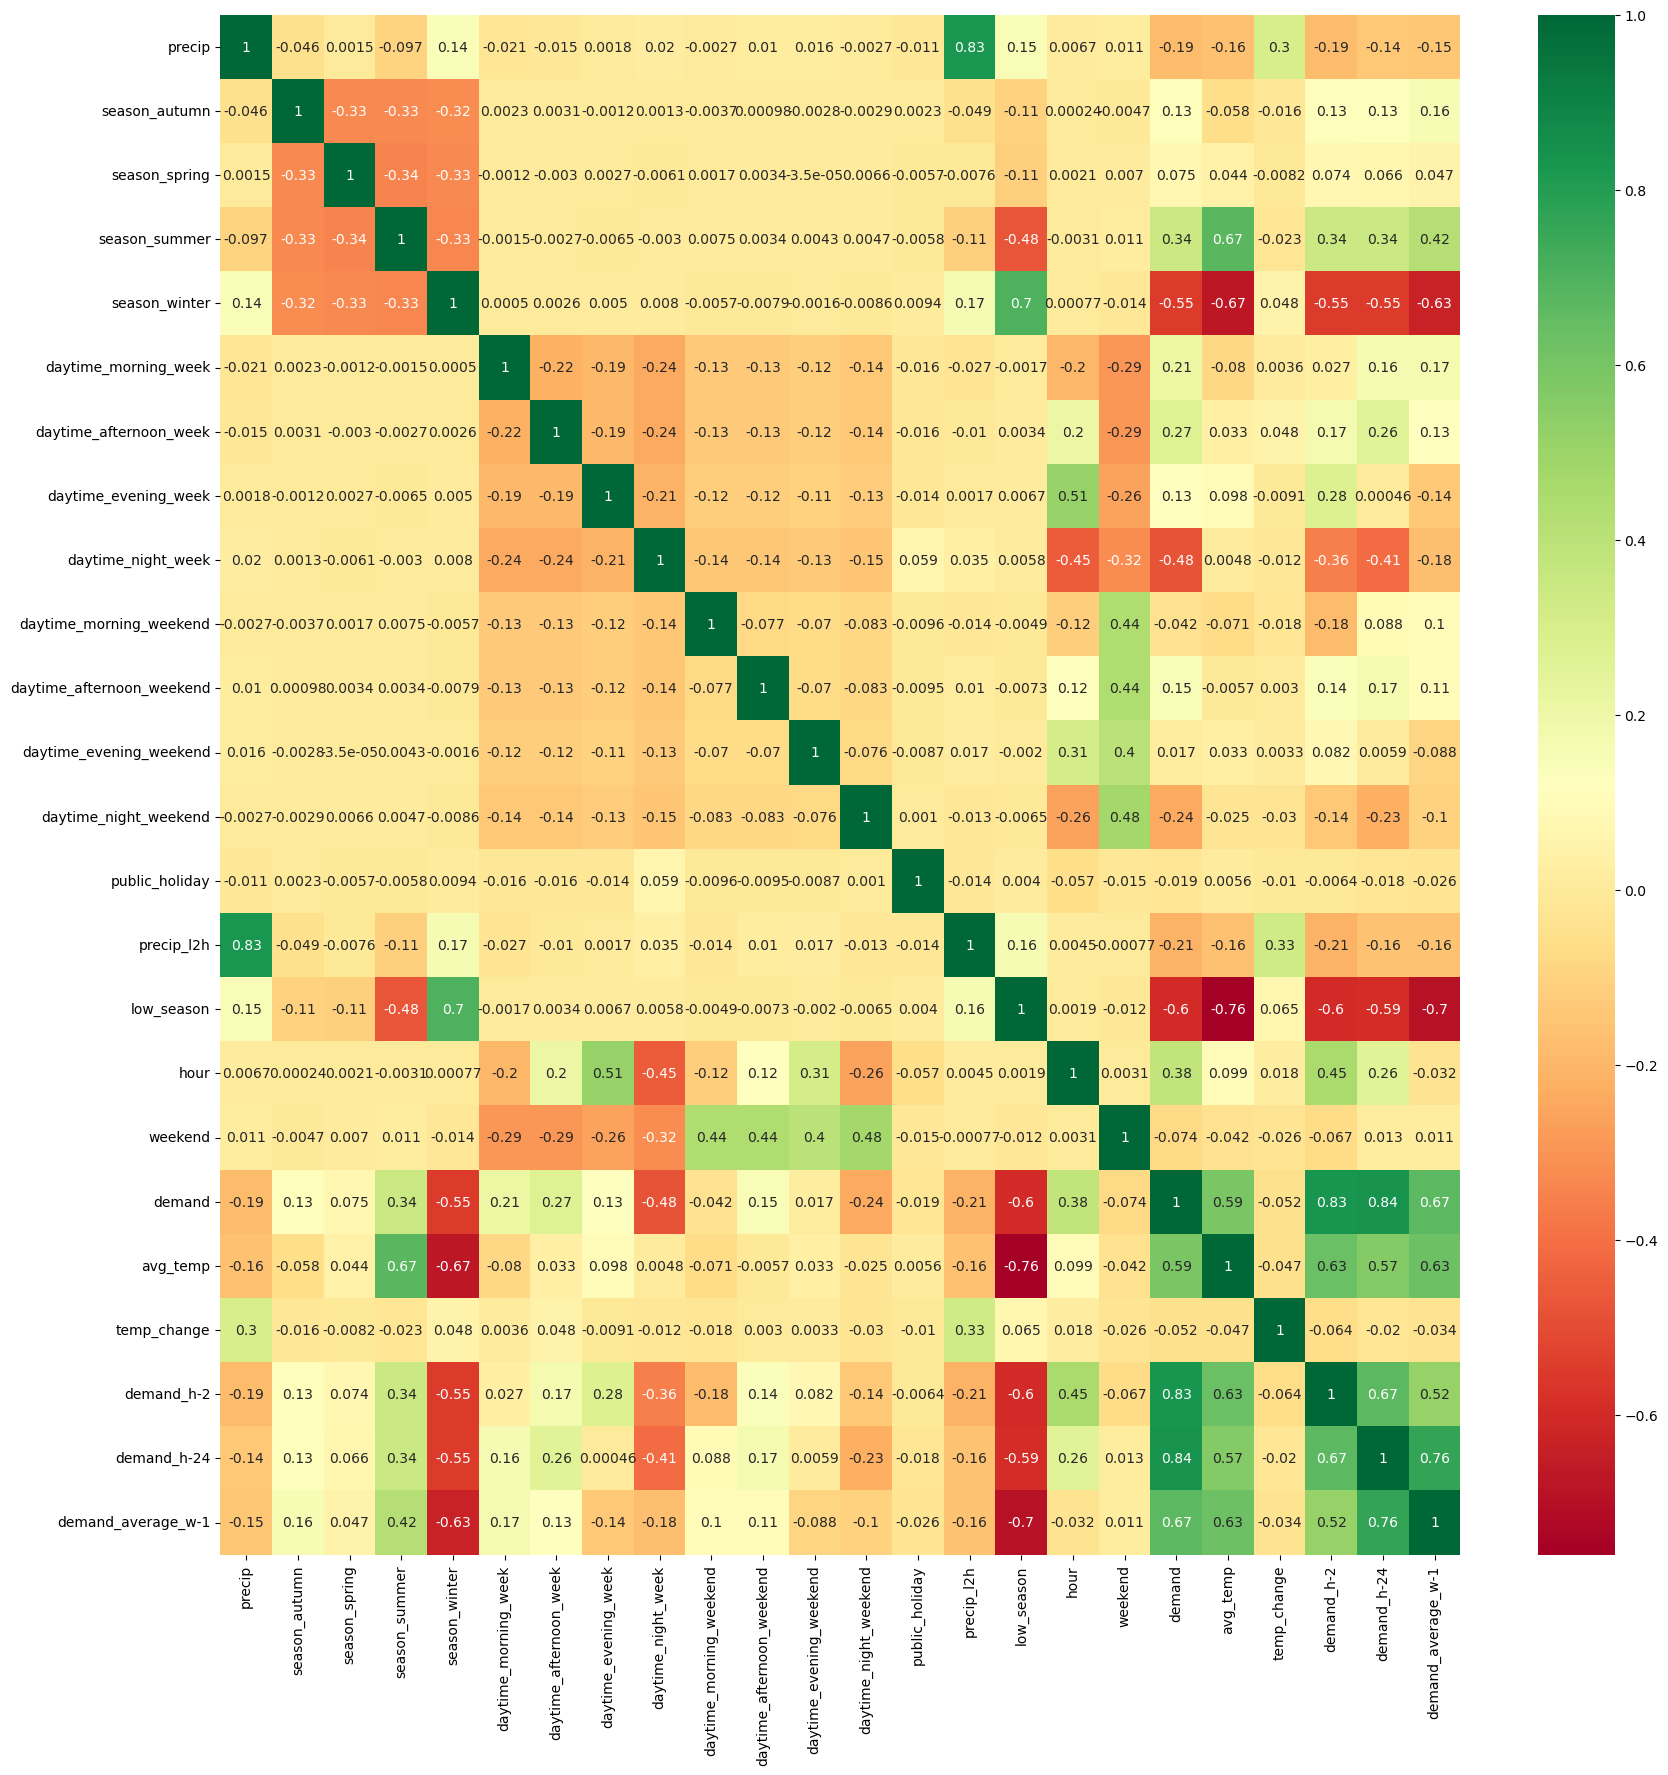

In [119]:
plt.figure(figsize=(20, 20))
sns.heatmap(pd.concat([ordinal, metric], axis=1).corr(method="spearman"), annot=True, cmap="RdYlGn")

## Model building

### Set Up Train and Test set

### Function for Hyperparameter Tuning

This function enables us to do hyperparameter tuning for any model in the sklearn universe. We have the choice to either do a RandomizedGridSearch with cross validation or a standard GridSearch, the latter is computationally heavier.

In [120]:
def optimize_hyperparameters(param_grid, model, X, y, randomized=False):
    if randomized:
        grid = RandomizedSearchCV(model, param_grid)
    else:
        grid = GridSearchCV(model, param_grid, verbose=3)

    grid.fit(X, y)
    print(f"Best params: {grid.best_params_}")
    print(f"Scoring: {grid.best_score_}")
    return grid

In [121]:
df_demand = df_demand.dropna()
features = ['max_temp', 'min_temp', 'precip', 'demand_h-2',
            'demand_h-24', 'demand_average_w-1', 'avg_temp',
            'temp_change',  'season_spring', 'season_summer', 'season_autumn', 'season_winter',
            'hour', 'weekend', "daytime_morning_week", "daytime_afternoon_week", "daytime_evening_week",
            "daytime_night_week", "daytime_morning_weekend", "daytime_afternoon_weekend", "daytime_evening_weekend",
            "daytime_night_weekend", 'public_holiday', 'precip_l2h', 'low_season']
target = 'demand'

X = df_demand[features]
y = df_demand[target]

scaler = StandardScaler()
X_scaled = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X.columns)
X_scaled_test = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X.columns)

#### Decision Tree Regression
As the very model we use a simple Decision Tree. Main advantages of using a Decision Tree Regressor is that it is easy to understand and interpret. The tree structure of the model makes it easy to visualize how the algorithm is making predictions. More over it is computationally rather inexpensive.

#### Hyperparameter tuning

In the following we do hyperparameter tuning for the decision tree. First of all we conduct a GridSearch on the `max_depth` parameter, which determines the maximum depth of the tree.


In [226]:
param_grid = {'max_depth': np.arange(6, 40, 2)}

TUNE = False
if TUNE:
    grid_search = optimize_hyperparameters(param_grid, DecisionTreeRegressor(), X_train, y_train, False)
    tree = DecisionTreeRegressor(**grid_search.best_params_)
else:
    tree = DecisionTreeRegressor(**{'max_depth': 10})

Now that we found the ideal parameters for max_depth, let's go one step further and optimize the tree by tuning ccp_alpha. This paramter controls tree pruning and helps avoiding the tree to overfit.

In [227]:
X_train_train = X_train[:int(0.8*len(X_train))]
y_train_train = y_train[:int(0.8*len(X_train))]
y_train_cv = y_train[int(0.8*len(X_train)):]
X_train_cv = X_train[int(0.8*len(X_train)):]
tree.fit(X_train_train, y_train_train)
path = tree.cost_complexity_pruning_path(X_train_train, y_train_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [228]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train_train, y_train_train)
    regs.append(reg)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        regs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 11757.932401253207


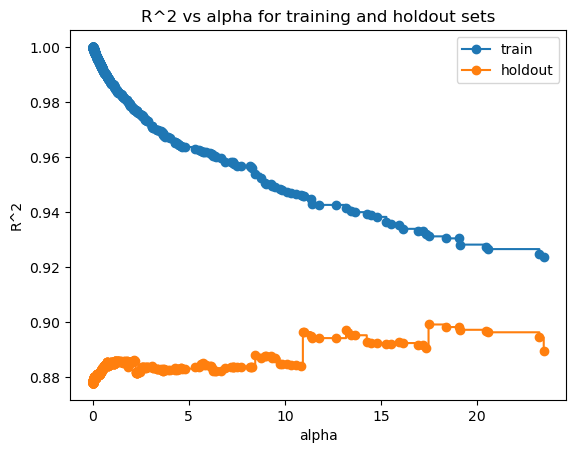

In [243]:
train_scores = [reg.score(X_train_train, y_train_train) for reg in regs]
test_scores = [reg.score(X_train_cv, y_train_cv) for reg in regs]
train_scores = train_scores[:-50]
test_scores = test_scores[:-50]
ccp_alphas_2 = ccp_alphas[:-50]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and holdout sets")
ax.plot(ccp_alphas_2, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas_2, test_scores, marker="o", label="holdout", drawstyle="steps-post")
ax.legend()
plt.show()


In the Graph we can see, that ccp alpha barely influences the models performance on the holdout set, nevertheless we set it to 12 as it seems to give us a slight performance improvement

In [238]:
tree = DecisionTreeRegressor(max_depth = 10, ccp_alpha=12)
tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=12, max_depth=10)

#### Decision Tree Visualization
Here we visualize the decision tree for explainability

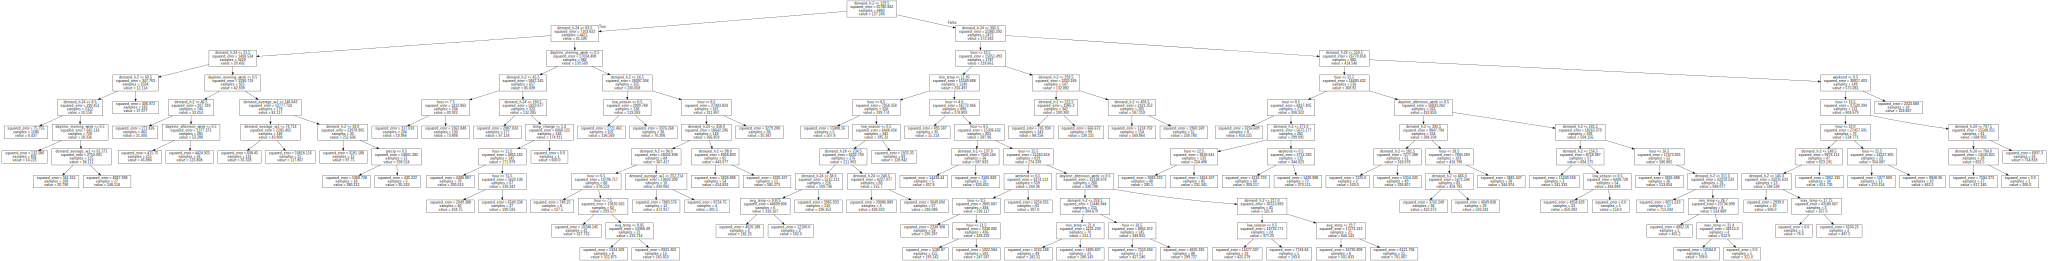

In [250]:
dot_data = export_graphviz(tree,feature_names=X_train.columns)  
graphviz.Source(dot_data)

#### Feature Importance

Text(0.5, 0, 'impurity-based feature importance')

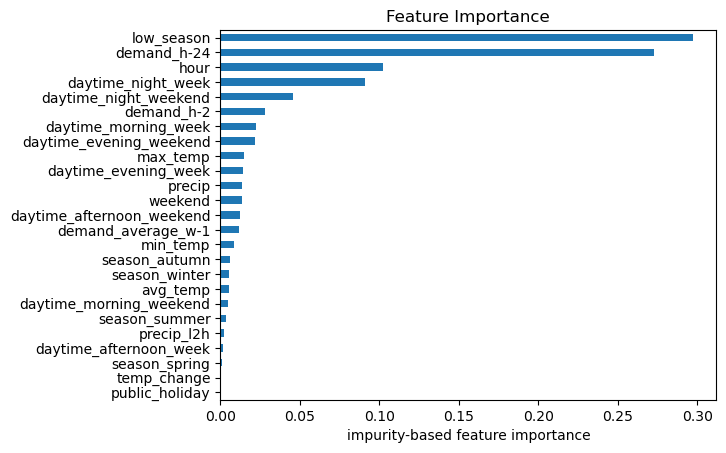

In [128]:
feat_importances = pd.Series(tree.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("impurity-based feature importance")

Here we can clearly see the model heavily bases its prediction on the demand of the day before hour and the binary variable low_seasom. This seems very logical, as the descriptive analysis has shown that demand does not change dramatically within two days. Also our correlation matrix has shown that these two features have high correlation with our target variable demand. Overall it is interesting to see that the `demand_h-2` is not the feature with the highest importance although it has the highest correlation in our correlation analysis.

### Random Forest

As the first model we pick the Random Forest as it is relatively easy to train and usually performs well on structured data. It is a type of ensemble model, which means that it is made up of multiple decision trees and it makes predictions by averaging the predictions of the individual trees. This can often result in a model that is more accurate and robust than any of the individual trees. Additionally, Random Forest models are resistant to overfitting, which is a common problem when training machine learning models. They are also easy to tune, as they only have a few hyperparameters that need to be set. Overall, Random Forest is a good model to use as a baseline, and it can often be improved upon by using more complex models.

#### Tuning the Hyperparameters
For finding a good set of hyperparameters we choose to do a GridsearchCV for the following hyperparameters:
* **n_estimators**: This is the number of trees in the forest. Increasing the number of trees can often improve the model's performance, but it can also increase the time it takes to train the model.
* **max_depth**: This is the maximum depth of each tree in the forest. Deeper trees can model more complex relationships, but they can also be more prone to overfitting.
* **max_features**: This is the maximum number of features that the model will consider when looking for the best split at each node. A smaller value can reduce the model's complexity and reduce the risk of overfitting, but it can also reduce the model's performance.


In [260]:
TUNE = False

# Hyperparameter tuning
param_grid = {'n_estimators': np.arange(50, 500, 50),
              'max_depth': [5, 15, 20, 30],
              'max_features': ['sqrt', 'log2', 0.7, 0.8, 0.9, 1]}
if TUNE:
    grid_search = optimize_hyperparameters(param_grid, RandomForestRegressor(), X_train, y_train, False)
    rf = RandomForestRegressor(**grid_search.best_params_, random_state=0)
else:
    rf = RandomForestRegressor(**{'max_depth': 20, 'max_features': 0.7, 'n_estimators': 250}, random_state=0)

If we compare this score with result of a model without any Hyperparameter tuning we can clearly see, that the tuning has a significant impact on the model performance.

#### Feature importance

The Feature Importance tells us which features the model deemed most important when making predictions. This can be useful for identifying the most important features for a given prediction task, and for understanding how the model is making predictions.

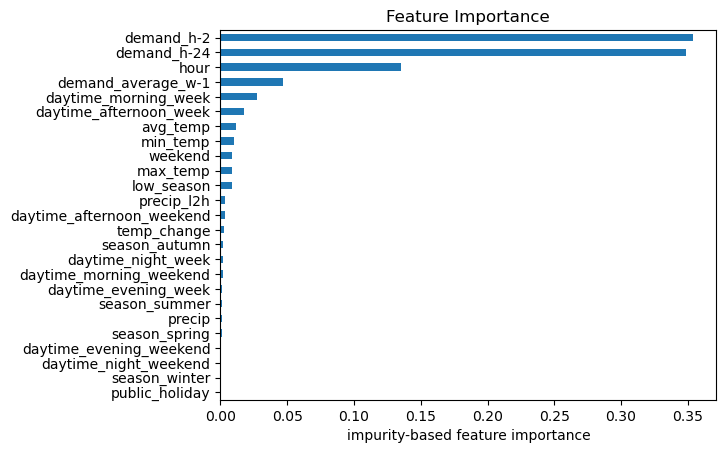

In [261]:
rf.fit(X_train, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("impurity-based feature importance")

plt.show()

As seen for the Decision Tree Regressor, also for the Random Forest model has `demand_h-24` as a feature with high importance. The `demand_h-2` which has the highest correlation with our target, has the highest importance.

### K-Nearest Neighbor

Our second model KNearestNeighbors (KNN) which is a good regressor to choose because of its simplicity and its ability to adapt to the structure of the data. KNN is a non-parametric method, which means that it does not make any assumptions about the underlying distribution of the data, making it a good choice for data that is complex or has non-linear relationships. Moreover KNN is also easy to interpret as it uses the known output values of the k nearest data points to predict the output for a new data point, making it easy to understand how the model is making predictions.

#### Hyperparameter tuning
We tune the model on the following hyperparameters:

* n_neighbors: The number of nearest neighbors to consider is an important hyperparameter to tune because it determines the number of data points that will be used to make predictions. The larger the smoother the prediction, the smaller the more to overfitted predictions.

* weights: The weighting method used to combine the predictions of the nearest neighbors is an important hyperparameter to tune because it determines how much weight is given to the different nearest neighbors. Different weighting methods can result in different predictions for the same data point. For example, using the 'uniform' weighting method will give equal weight to all nearest neighbors, while using the 'distance' weighting method will give more weight to nearest neighbors that are closer to the data point being predicted.

* p: The power parameter for the Minkowski distance metric is an important hyperparameter to tune because it determines the type of distance metric used to calculate distances between data points. The default value is p=2, which corresponds to the Euclidean distance. For p=1 the Manhattan distance is used.


In [258]:
param_grid = {'n_neighbors':np.arange(1,100,1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}

TUNE = False
if TUNE:
    grid_search = optimize_hyperparameters(param_grid, KNeighborsRegressor(), X_scaled_train, y_train, False)
    knn = KNeighborsRegressor(**grid_search.best_params_)
else:
    knn = KNeighborsRegressor(**{'n_neighbors': 10, 'p': 1, 'weights': 'distance'})

knn.fit(X_scaled_train, y_train)


KNeighborsRegressor(n_neighbors=10, p=1, weights='distance')

## Polynomial Regression
Our third model is based on polynomial regression. Since the relationship between demand and temperature is non-linear, polynomial regression is appropriate.

### Cross validation
To avoid overfitting of the polynomial regression model, it is common practice to split the training set again into train and cross validation (cv) set. The training of the model is done on the training set, after which evluation is done on the validation (holdout) set. When the experiment seems to be successful, the final evaluation of the model can be done on the test set.

In [132]:
X_scaled_train_reduced = X_scaled_train[['demand_h-2', 'low_season', 'season_winter', 'daytime_night_week', 'avg_temp']]
X_scaled_test_reduced = X_scaled_test[['demand_h-2', 'low_season', 'season_winter', 'daytime_night_week', 'avg_temp']]

X_scaled_train_cv, X_scaled_holdout_cv, y_train_cv, y_holdout_cv = train_test_split(X_scaled_train_reduced.values, y_train.values, test_size=0.3)

current degree: 0
current degree: 1
current degree: 2
current degree: 3
current degree: 4
current degree: 5
current degree: 6
current degree: 7
current degree: 8
current degree: 9


Text(0, 0.5, 'Root mean squared error')

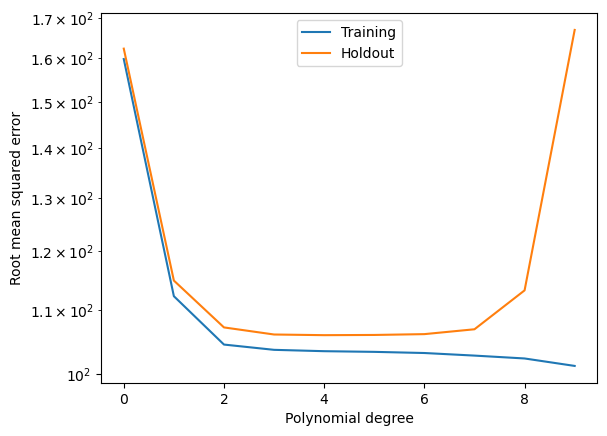

In [163]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
maxdeg = range(0,10)
training_error, validation_error = [],[]

for d in maxdeg:
    
    print(f'current degree: {d}')
    # compute polynomial features
    x_poly_train = PolynomialFeatures(degree = d).fit_transform(X_scaled_train_cv)
    x_poly_holdout = PolynomialFeatures(degree = d).fit_transform(X_scaled_holdout_cv)
    
    # Initialize linear regression model and train and on train data
    lreg = LinearRegression(fit_intercept=False)
    lreg.fit(x_poly_train, y_train_cv)
    
    # Predict with train and holdout data
    y_train_pred = lreg.predict(x_poly_train)
    y_holdout_pred = lreg.predict(x_poly_holdout)
    
    # Calculate RMSE
    training_error.append(math.sqrt(mean_squared_error(y_train_cv, y_train_pred)))
    validation_error.append(math.sqrt(mean_squared_error(y_holdout_cv, y_holdout_pred)))

plt.semilogy(maxdeg,training_error,maxdeg,validation_error)
plt.legend(["Training", "Holdout"])
plt.xlabel("Polynomial degree")
plt.ylabel("Root mean squared error")

Looking at the plot, a polynomial degree of 3 has the lowest error on the validation set. Additionally due to the simplicity of degree 3, we decide to use it as polynomial degree. Now we calculate the RMSE for predicting the bike demand.

In [165]:
x_poly_train2 = PolynomialFeatures(degree = 3).fit_transform(X_scaled_train_reduced.values)
x_poly_test2 = PolynomialFeatures(degree = 3).fit_transform(X_scaled_test_reduced.values)
lreg2 = LinearRegression(fit_intercept=False)
lreg2.fit(x_poly_train2, y_train.values)
y_test_pred2 = lreg2.predict(x_poly_test2)
print ('RMSE: ',math.sqrt(mean_squared_error(y_test, y_test_pred2)))

RMSE:  102.50176376340103


## Regularization
The degree of the polynomial acts as a characterization of the model complexity. The magnitude is another notion of model complexity. With extremely high values for the coefficients, we get the polynomial to exactly pass through the points. The goal is, that the different polynomial terms largely "cancel" out precisely at the data points and fit the function exactly to the data. With regularization, we are able to control the complexity of the model class and restrict the magnitude of the coefficients.

### Regularization with ridge regression
With the ridge regression the sum of squares (2-norms) of the model coefficients is penalized. $\lambda$ is a free parameter that controls the strength of the penalty. To choose this parameter, we compute the training and validation errors for different amount of regularization, just as we did before with the degree of the polynomial.

Text(0, 0.5, 'Root mean squared error')

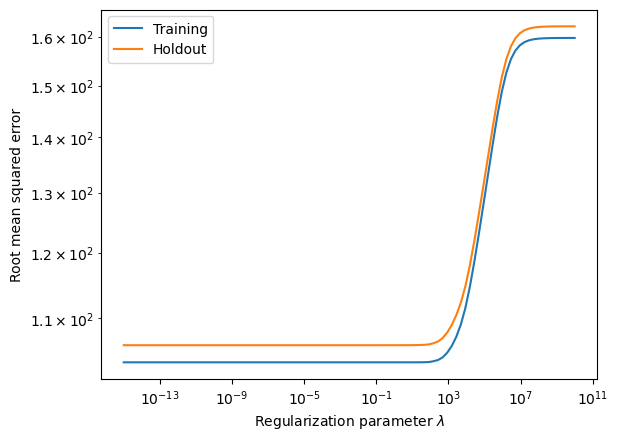

In [168]:
from sklearn.linear_model import Ridge
lam = np.logspace(-15,10,100)
training_error_ridge, validation_error_ridge = [],[]

for l in lam:
    Poly = PolynomialFeatures(degree = 3)
    X_poly_train = Poly.fit_transform(X_scaled_train_cv)
    X_poly_holdout = Poly.fit_transform(X_scaled_holdout_cv)
    model_L2 = Ridge(alpha = l, solver = 'lsqr')
    model_L2.fit(X_poly_train, y_train_cv)
    y_train_ridge_pred = model_L2.predict(X_poly_train)
    y_holdout_ridge_pred = model_L2.predict(X_poly_holdout)
    training_error_ridge.append(math.sqrt(mean_squared_error(y_train_cv, y_train_ridge_pred)))
    validation_error_ridge.append(math.sqrt(mean_squared_error(y_holdout_cv, y_holdout_ridge_pred)))

plt.loglog(lam,training_error_ridge,lam,validation_error_ridge)
plt.legend(["Training", "Holdout"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Root mean squared error")

The curve hardly changes in the range from $\lambda$ = 10<sup>-13</sup> to $\lambda$ = 10<sup>3</sup>. From then on, both curves increase with increasing regularization parameter. We thus zoom into the range from $\lambda$ = 10<sup>-2</sup> to $\lambda$ = 10<sup>2</sup>.

Text(0, 0.5, 'Root mean squared error')

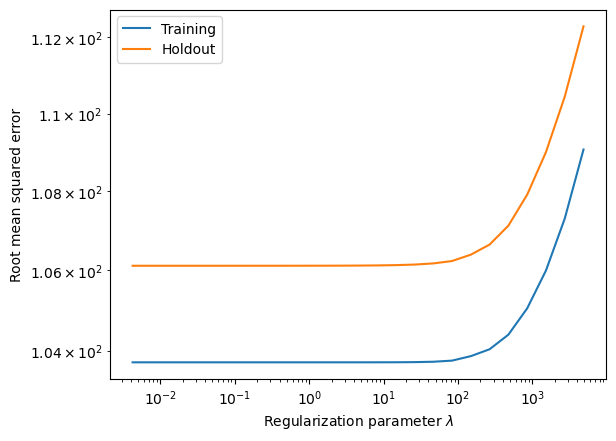

In [169]:
plt.loglog(lam[50:75],training_error_ridge[50:75],lam[50:75],validation_error_ridge[50:75])
plt.legend(["Training", "Holdout"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Root mean squared error")

The plot suggests that regularization parameters between 10<sup>-2</sup> to $\lambda$ = 10<sup>1</sup> work best for our data set. We thus use a regularization parameter of 10<sup>1</sup> = 10, since a larger regularization parameter reduces model complexity and increases regularization.

In [170]:
Poly = PolynomialFeatures(degree = 3)
X_poly_train = Poly.fit_transform(X_scaled_train)
X_poly_test = Poly.fit_transform(X_scaled_test)

model_L2 = Ridge(alpha = 10, solver = 'lsqr')

model_L2.fit(X_poly_train, y_train)
prediction = model_L2.predict(X_poly_test)

print ('RMSE: ',math.sqrt(mean_squared_error(y_test, prediction)))

RMSE:  70.37743561944565


## XG Boost

XGBoost (eXtrene Gradient Boosting) is an open source library that uses a parallel tree algorithm with gradient boosting. It can be used regressions, ranking and classification and is therefore also a possible candidate to try out.

/home/bsauter/anaconda3/envs/handsOn/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE: 35.158120


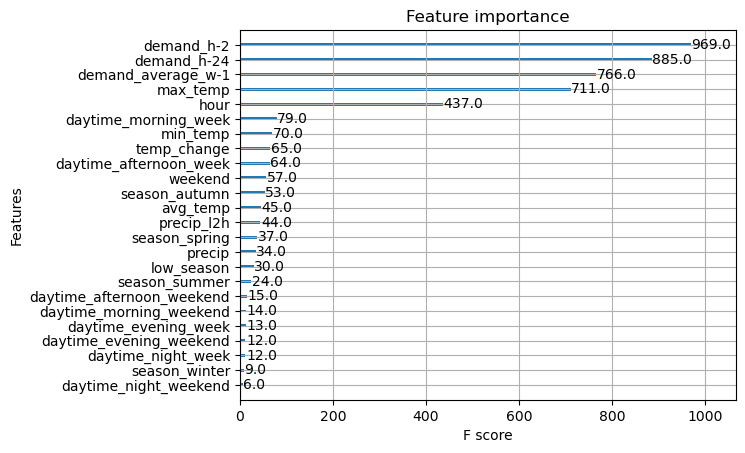

<Figure size 1600x1200 with 0 Axes>

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Training/test sets split with 0.2 and defined random_state
# X_train, X_test, y_train, y_test

# Simple xg regression without hyperparameter tuning

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')


xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


#Feature Importance
xgb.plot_importance(xg_reg)
plt.figure(figsize=(16,12))
plt.show()

In [139]:
# hyperparameter tuning
from xgboost import cv
import numpy as np

params = {
    'learning_rate': [0.15], 
    'min_split_loss': np.arange(2, 2.5, 0.1),
    'max_depth': [6],
    'min_child_weight': np.arange(0, 4, 0.2),
    'subsample': np.arange(0.5, 0.8, 0.1),
    'colsample_bytree': np.arange(0.8, 0.95, 0.05),
}

#{'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 3.2, 'min_split_loss': 2.0, 'subsample': 0.7999999999999999} -> no further improvement
params_tuned = {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 6, 'min_split_loss': 2.1, 'subsample': 0.8}


TUNE=False

if TUNE:
    grid_search_results = optimize_hyperparameters(params, xg_reg, X_train, y_train, False)
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **grid_search_results)
else:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **params_tuned)

Relevant hyperparamters:
- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- min_split_loss: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma/min_split_loss is, the more conservative the algorithm will be.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.


/home/bsauter/anaconda3/envs/handsOn/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE: 33.813630


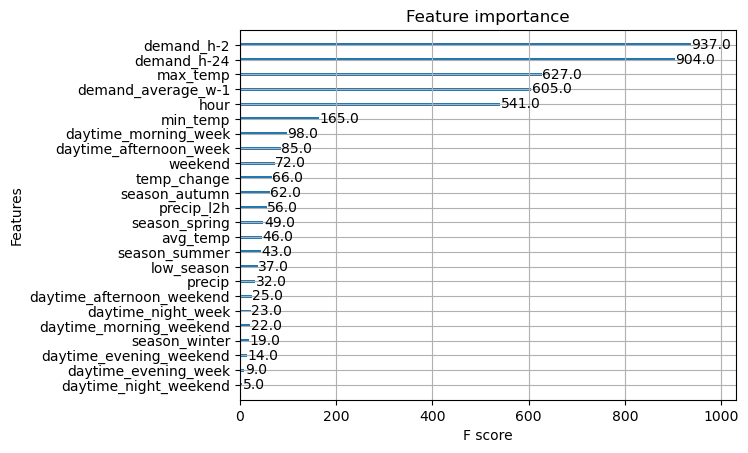

<Figure size 1600x1200 with 0 Axes>

In [140]:
# Training + Prediciton/Evaluation
xg_reg.fit(X_train,y_train)

preds_tuned_model = xg_reg.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, preds_tuned_model))
print("RMSE: %f" % (rmse))

#Feature Importance
xgb.plot_importance(xg_reg)
plt.figure(figsize=(16,12))
plt.show()


The Feature importance plot of XGBoost also shows that it also heavily depends on features that contain the previous demand.

## Model Evaluation

Now let's evaluate the model performances by using the following metrics:
* RMSE: Square root of average difference between the actual and estimated value
* MAE: The average absolute error
* R2: Proportion of the variance that is captured by the model
By evaluating the models on these three metrics, we are able to evaluate model performance from different angles.

In [262]:
models = [rf, tree, xg_reg, knn, model_L2]
model_names = ['Random Forest', 'Decision Tree', 'XGBoost', 'KNearestNeighbors', 'Polynomial Regression']
results = []
for model, model_name in zip(models, model_names):

    if model_name in ['KNearestNeighbors']:
        y_pred = model.predict(X_scaled_test)
    if model_name in ['Polynomial Regression']:
        y_pred = model.predict(X_poly_test)
    elif model_name in ['Random Forest', 'Decision Tree', 'XGBoost']:
        print()
        y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([model_name, rmse, mae, r2])

df_model_results = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])

df_model_results.head()

,Model,RMSE,MAE,R2
0,Random Forest,35.691161,18.384137,0.949192
1,Decision Tree,48.291669,27.243558,0.906985
2,XGBoost,33.813630,18.077920,0.954397
3,KNearestNeighbors,55.441524,28.686799,0.877403
4,Polynomial Regression,70.377436,41.095043,0.802450


The table above illustrates the performance of the four machine learning models we have used to forecast bike demand. It is evident that the tree-based models, Random Forest, XGBoost, and Decision Tree, outperform the KNN and Polynomial Regression models. As expected, the more sophisticated models, Random Forest and XGBoost, have shown better results than the simple Decision Tree. These two models use the Decision Tree as their core structure, but intelligently combine multiple decision trees together to improve prediction results. On the given dataset, this approach seems to be effective, leading to a significantly better performance.

XGBoost and Random Forest show very similar performance, and further hyperparameter tuning may change the outcome. However, as of now, we can state that XGBoost is the strongest model among the five. The Polynomial Regression model had to be trained and tuned with a reduced number of input features due to limitations with our computing capacity. It can be expected that the model might show further performance improvements when trained and tuned with more input features.

Furthermore, the models show consistent results on all three metrics, which proves that we have robust results, and no model has particular flaws. Overall, the XGBoost model can be considered as the best model for this dataset based on the evaluation metric used.